# Investigating left-right and starter bias in Galaxy Zoo Wars

In [1]:
from astropy.io import fits
import astropy.table as tab
from astropy.table import Table
from astropy.stats import poisson_conf_interval
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math
import random
import pickle
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = None

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
colors = ['r','b','g','y']
colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [3]:
wars = Table.read('gz2spiralwars.fits.gz')
#wars = Table.read('gz2barwars.fits.gz')

In [4]:
wars

wars_classification_id,match_classification_id,annotation_id,task_id,user_id,starter_asset_id,winner_asset_id,loser_asset_id,winner_objid,loser_objid,winner_sample,loser_sample,redshift_bin,magsize_bin,battle_bin
int32,int32,int32,int16,int32,int32,int32,int32,int64,int64,str16,str16,int32,int32,int32
3,2,12,13,142530,26141,21706,26141,587727866183418090,587728880871997672,original,original,5,88,88005
13,11,50,13,146195,187443,187443,103201,587745402538885394,587736975808135174,original,original,7,73,73007
20,18,83,13,101133,81602,81602,258,587735349087764824,587722982284001433,original,original,7,36,36007
27,25,104,13,101133,79802,79802,85024,587735344795353288,587735665848615041,original,original,11,23,23011
29,28,113,13,101133,186520,124737,186520,587739380993163399,587745243624505467,original,original,7,72,72007
45,44,169,13,142530,19804,19804,108876,587726033847779454,587738195050954892,original,original,8,22,22008
48,46,179,13,146195,22535,22535,61372,587727944029962369,587732770502279188,original,original,0,15,15000
90,87,334,13,172445,59917,59917,183421,587732702324392186,587742863132852363,original,original,8,61,61008
93,88,339,13,61063,60632,60632,22790,587732703396692127,587728307485605994,original,original,3,45,45003


In [5]:
starter_win = wars['starter_asset_id'] == wars['winner_asset_id']
starter_lose = wars['starter_asset_id'] == wars['loser_asset_id']

The starter tends to win, as the classifier has just decided that it has the feature in question, whereas its opponent is simply drawn from all galaxies with similar luminosity, size and redshift.

In [6]:
print(starter_win.sum(), starter_lose.sum())

795863 210168


For some reason there are a small number of wars where the starter id does not match the winner or loser!
Note that the identification of the starter id does rely on searching previous classifications for a match.
There must be a small number of occasions where this matching fails, but I'm not going to redo all that now.
There are also a set of wars where the same galaxy is on both sides!  Unfortunately, we don't know whether the galaxy on the left or the right won. Just remove these wars from the table.

In [7]:
print('Starter mismatch:', (~(starter_win | starter_lose)).sum())
print('Same winner and loser:', (starter_win & starter_lose).sum())
wars = wars[(starter_win | starter_lose) & ~(starter_win & starter_lose)]

Starter mismatch: 6542
Same winner and loser: 6470


Checking in more detail how the starter influences the result.  For each pair, denote one 'A' and the other 'B' (by ordering their ids - randomly permuted so this doesn't introduce a bias).  Find groups of wars between the same pair of galaxies.  Then count how often each wins when it is the starter or opponent.

For pairs where one member starts most of the wars, it will be expected to win most, for same reason as above.  However, on average, and especially where both pairs start an equal number of wars, on would expect 'A' to win as many wars when starter as when opponent.  Any deviation suggests that being starter has an influence.  We see that this is the case, with the starter gaining an advantage of ~8 percent.  However, assuming that the starter galaxy always appears on one side, we can't tell if this is due to a left-right preference, or a preference for the galaxy they have been looking at for longer.

In [8]:
max_id = max(wars['winner_asset_id'].max(), wars['loser_asset_id'].max()) + 1
alt_id = np.random.permutation(max_id)
inv_alt_id = np.argsort(alt_id)

A = np.minimum(alt_id[wars['winner_asset_id']], alt_id[wars['loser_asset_id']])
B = np.maximum(alt_id[wars['winner_asset_id']], alt_id[wars['loser_asset_id']])

wars['A'] = inv_alt_id[A]
wars['B'] = inv_alt_id[B]

grouped = wars.group_by(['A', 'B'])

n_in_group = np.diff(grouped.groups.indices)
grouped = grouped.groups[n_in_group > 1]

grouped['A_wins'] = grouped['A'] == grouped['winner_asset_id']
grouped['B_wins'] = grouped['B'] == grouped['winner_asset_id']
grouped['A_starts'] = grouped['A'] == grouped['starter_asset_id']
grouped['B_starts'] = grouped['B'] == grouped['starter_asset_id']
grouped['A_starts_and_A_wins'] = grouped['A_starts'] & grouped['A_wins']
grouped['B_starts_and_A_wins'] = grouped['B_starts'] & grouped['A_wins']
grouped['A_starts_and_B_wins'] = grouped['A_starts'] & grouped['B_wins']
grouped['B_starts_and_B_wins'] = grouped['B_starts'] & grouped['B_wins']
grouped['A_and_B_same'] = grouped['A'] == grouped['B']

In [9]:
n_A_starts = grouped['A_starts'].groups.aggregate(np.sum)
n_B_starts = grouped['B_starts'].groups.aggregate(np.sum)
n_total = np.diff(grouped.groups.indices)
n_groups = len(grouped.groups)
n_A_starts_and_A_wins = grouped['A_starts_and_A_wins'].groups.aggregate(np.sum)
n_B_starts_and_A_wins = grouped['B_starts_and_A_wins'].groups.aggregate(np.sum)
n_A_starts_and_B_wins = grouped['A_starts_and_B_wins'].groups.aggregate(np.sum)
n_B_starts_and_B_wins = grouped['B_starts_and_B_wins'].groups.aggregate(np.sum)
same_A_and_B = grouped['A_and_B_same'].groups.aggregate(np.logical_and)

In [10]:
print(n_total[same_A_and_B].sum(), len(grouped[grouped['A_and_B_same']]))
print(n_total[~same_A_and_B].sum(), len(grouped[~grouped['A_and_B_same']]))

0 0
126958 126958


In [11]:
def print_table(ok):
    f = np.zeros((2,2))
    f[0,0] = n_A_starts_and_A_wins[ok].sum() / n_total[ok].sum()
    f[0,1] = n_A_starts_and_B_wins[ok].sum() / n_total[ok].sum()
    f[1,0] = n_B_starts_and_A_wins[ok].sum() / n_total[ok].sum()
    f[1,1] = n_B_starts_and_B_wins[ok].sum() / n_total[ok].sum()
    print('{:8s} {:>8s} {:>8s}'.format('', 'A wins', 'B wins'))
    print('{:8s} {:8.3f} {:8.3f}'.format('A starts', f[0, 0], f[0, 1]))
    print('{:8s} {:8.3f} {:8.3f}'.format('B starts', f[1, 0], f[1, 1]))
    print('sum = {:.3f}'.format(f.sum()))

In [12]:
print('n_A > n_B')
print_table(n_A_starts > n_B_starts)

n_A > n_B
           A wins   B wins
A starts    0.797    0.176
B starts    0.013    0.014
sum = 1.000


In [13]:
print('n_A < n_B')
print_table(n_A_starts < n_B_starts)

n_A < n_B
           A wins   B wins
A starts    0.014    0.014
B starts    0.174    0.799
sum = 1.000


In [14]:
print('n_A == n_B')
print_table(n_A_starts == n_B_starts)

n_A == n_B
           A wins   B wins
A starts    0.287    0.213
B starts    0.204    0.296
sum = 1.000


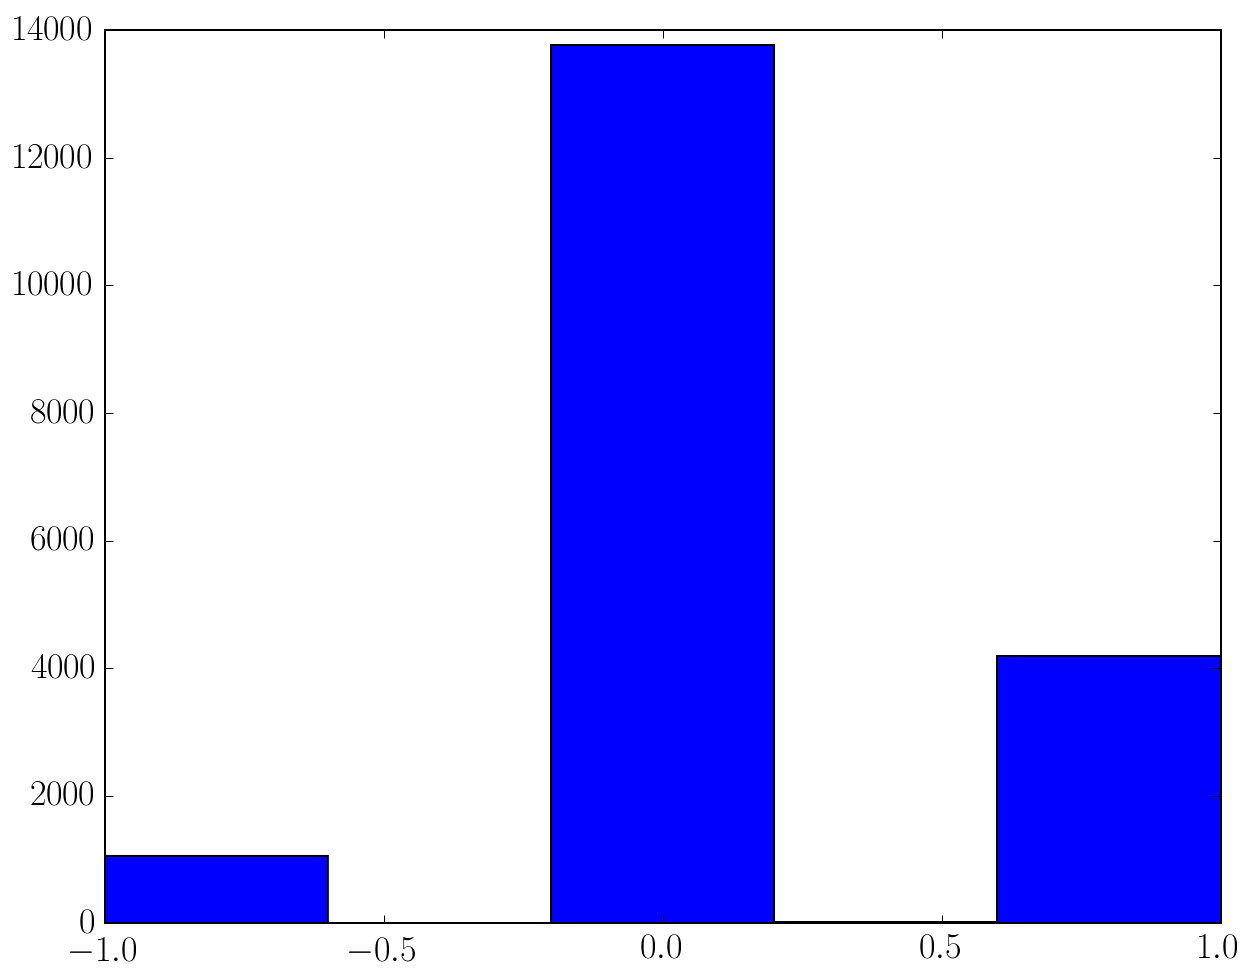

In [15]:
# only select groups where there are as many A starts as B starts
ok = n_A_starts == n_B_starts

f_A_wins_when_A_starts = n_A_starts_and_A_wins[ok] / n_A_starts[ok]
f_A_wins_when_B_starts = n_B_starts_and_A_wins[ok] / n_B_starts[ok]

_ = plt.hist(f_A_wins_when_A_starts - f_A_wins_when_B_starts, bins=5)

Could investigate further by looking into how this depends on the strength of the feature, from the normal vote fraction or the wars rank.